# Data
- Lead scoring dataset from UCI
    - https://archive.ics.uci.edu/dataset/222/bank+marketing

# Methods
- Feature Engineering
    - Scaled numerical features to have mean of 0 and variance of 1
    - Features are binned using Chi-square tests
    - Information value (IV) calculated for the bins
    - Features with an IV over 0.1 are selected
- Model
    - Logistic regression trained on the data with the bins used as features
    - Scoring system created with a range of 0 to 100
    - Feature bins are assigned points, where more points are associated with a lead more likely to convert

In [98]:
import pandas as pd
import numpy as np
from optbinning import OptimalBinning, BinningProcess, Scorecard
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV


from matplotlib import pyplot as plt
from optbinning.scorecard import plot_auc_roc
import seaborn as sns

In [99]:
df = pd.read_csv("data/raw/bank-additional/bank-additional-full.csv", delimiter=";")

In [100]:
df = df.drop(columns=["duration", "previous", "poutcome"])

In [102]:
cat_cols = ["job", "marital", "education", "default", 
            "housing", "loan", "contact", "month", 
            "day_of_week"]
num_cols = df.columns.difference(cat_cols + ["y"]).tolist()
for c in cat_cols:
    print(f"{c}: {len(df[c].unique())} categories")

job: 12 categories
marital: 4 categories
education: 8 categories
default: 3 categories
housing: 3 categories
loan: 3 categories
contact: 2 categories
month: 10 categories
day_of_week: 5 categories


In [103]:
x_train, x_test, y_train, y_test = train_test_split(df, df["y"], test_size=0.3)
ct = ColumnTransformer([
        ('scaler', StandardScaler(), num_cols)
    ], remainder='passthrough')

x_train_scaled = ct.fit_transform(x_train)
x_test_scaled = ct.transform(x_test)

In [104]:
x = df[df.columns.difference(["y"])]
y = df["y"].map(lambda x: 0 if x == "no" else 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

selection_criteria = {"iv": {"min": 0.1, "max": 1}}
bins = BinningProcess(x.columns.to_list(), selection_criteria=selection_criteria)
model = LogisticRegression()
scorecard = Scorecard(
    binning_process=bins,
    estimator=model,
    scaling_method="min_max",
    scaling_method_params={
        "min": 0,
        "max": 100
    },
    reverse_scorecard=True
)
scorecard.fit(x_train, y_train)

Scorecard(binning_process=BinningProcess(selection_criteria={'iv': {'max': 1,
                                                                    'min': 0.1}},
                                         variable_names=['age', 'campaign',
                                                         'cons.conf.idx',
                                                         'cons.price.idx',
                                                         'contact',
                                                         'day_of_week',
                                                         'default', 'education',
                                                         'emp.var.rate',
                                                         'euribor3m', 'housing',
                                                         'job', 'loan',
                                                         'marital', 'month',
                                                         'nr.employed',
                                                         'pdays']),
          estimator=LogisticRegression(), reverse_scorecard=True,
          scaling_method='min_max',
          scaling_method_params={'max': 100, 'min': 0})

In [105]:
scorecard.table()

,Variable,Bin,Points
0,age,"(-inf, 26.50)",9.360072
1,age,"[26.50, 30.50)",6.270880
2,age,"[30.50, 33.50)",4.852994
3,age,"[33.50, 38.50)",4.031077
4,age,"[38.50, 43.50)",3.074777
5,age,"[43.50, 45.50)",2.540702
6,age,"[45.50, 49.50)",2.305393
7,age,"[49.50, 57.50)",4.395572
8,age,"[57.50, inf)",12.044530
9,age,Special,5.190524


0.772077921593281


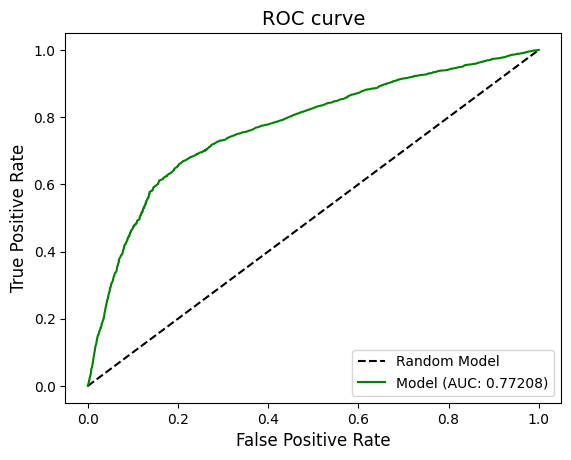

In [106]:
y_pred = scorecard.predict_proba(x_train)[:, 1]
print(roc_auc_score(y_train, y_pred))

plot_auc_roc(y_train, y_pred)

plt.show()

0.768608967074388


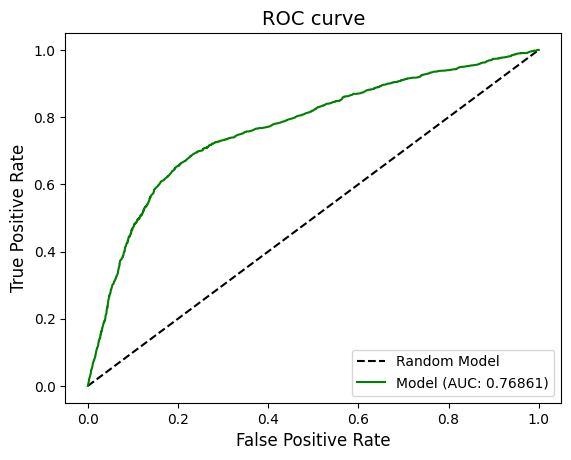

In [107]:
y_pred = scorecard.predict_proba(x_test)[:, 1]
print(roc_auc_score(y_test, y_pred))

plot_auc_roc(y_test, y_pred)

plt.show()

<Axes: ylabel='Count'>

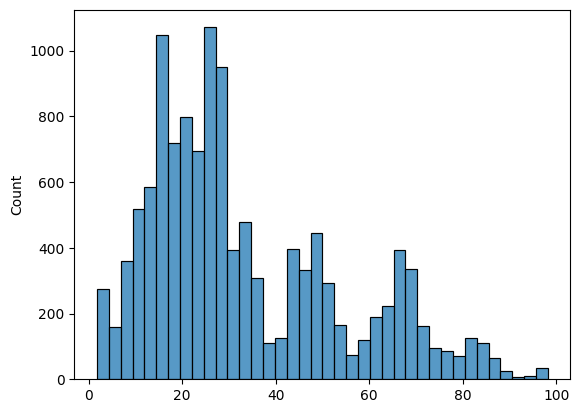

In [108]:
y_score = scorecard.score(x_test)
sns.histplot(y_score)

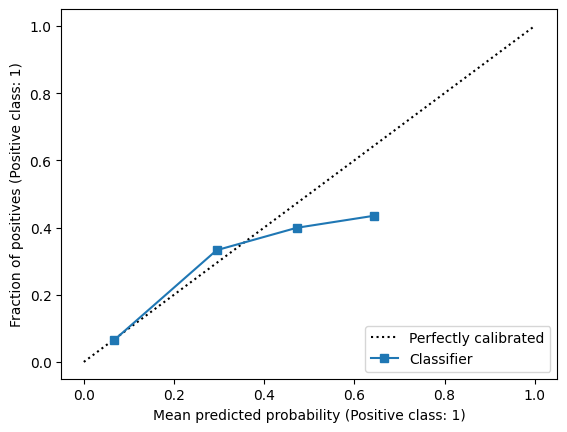

In [109]:
CalibrationDisplay.from_predictions(y_test, scorecard.predict_proba(x_test)[:, -1])